In [1]:
# --- Imports Fundamentales ---
import joblib
import json
import glob
import re
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# --- Estilo de Figuras para Publicación (Estilo Nature/Cell) ---
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 300
})
sns.set_style("whitegrid")
warnings.filterwarnings('ignore', category=UserWarning)

# --- Rutas del NUEVO Experimento ---
RESULTS_DIR = Path("./resultados33") # <-- ¡ÚNICO LUGAR PARA CAMBIAR LA RUTA!
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# --- Detección y Carga Automática de Archivos ---
try:
    # Usa glob para encontrar el archivo CSV, ya que el nombre es largo
    csv_path_list = glob.glob(str(RESULTS_DIR / "all_folds_metrics_MULTI_*.csv"))
    if not csv_path_list:
        raise FileNotFoundError("No se encontró el archivo CSV de métricas.")
    CSV_PATH = csv_path_list[0]
    
    # Extrae el sufijo único del nombre del archivo para encontrar los demás
    match = re.search(r"MULTI_(.+)\.csv", CSV_PATH)
    if not match:
        raise ValueError("No se pudo extraer el sufijo del nombre del archivo CSV.")
    SUFFIX = match.group(1)
    
    HIST_PATH = RESULTS_DIR / f"all_folds_vae_training_history_{SUFFIX}.joblib"
    PRED_PATH = RESULTS_DIR / f"all_folds_clf_predictions_MULTI_{SUFFIX}.joblib"
    
    print(f"✅ Archivos encontrados para el experimento:\n    {SUFFIX}")

    # Carga de Datos
    metrics_df = pd.read_csv(CSV_PATH)
    histories = joblib.load(HIST_PATH)
    predictions = joblib.load(PRED_PATH)
    
    # Determinar el mejor clasificador basado en la métrica objetivo
    scoring_metric = metrics_df.columns[metrics_df.columns.str.contains("auc_bal", case=False)][0]
    best_clf_name = metrics_df.groupby('classifier')[scoring_metric].mean().idxmax()
    print(f"🏆 Mejor clasificador identificado: '{best_clf_name}' (basado en '{scoring_metric}')")

except (FileNotFoundError, ValueError, IndexError) as e:
    print(f"❌ ERROR: {e}\n   Asegúrate de que la ruta '{RESULTS_DIR}' es correcta y el pipeline ha finalizado.")
    metrics_df, histories, predictions, best_clf_name = None, None, None, None

✅ Archivos encontrados para el experimento:
    xgb_vaeconvtranspose4l_ld256_beta1.1_normzscore_offdiag_ch2sel_intFChalf_drop0.25_ln1_outer5x1_scoreauc_bal07
🏆 Mejor clasificador identificado: 'xgb' (basado en 'auc_bal07')


In [2]:
if metrics_df is not None:
    # Diccionario para renombrar métricas a un formato más legible
    key_metrics = {
        scoring_metric: 'Score Compuesto (AUC*0.7 + Bal.Acc*0.3)',
        'auc': 'AUC-ROC',
        'bal_acc_def': 'Balanced Accuracy',
        'sens_def': 'Sensibilidad (Recall)',
        'spec_def': 'Especificidad',
        'pr_auc': 'AUC-PR'
    }
    
    # Filtrar por el mejor clasificador y las métricas clave
    df_summary = metrics_df[metrics_df['classifier'] == best_clf_name][list(key_metrics.keys())]
    
    # Calcular media y desviación estándar
    summary_stats = df_summary.agg(['mean', 'std']).T
    summary_stats.index = summary_stats.index.map(key_metrics)
    summary_stats['Rendimiento (Media ± DE)'] = summary_stats.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1)
    
    table1 = summary_stats[['Rendimiento (Media ± DE)']]
    table1.index.name = 'Métrica de Evaluación'
    
    print(f"\n--- Tabla 1: Rendimiento del Modelo Óptimo ({best_clf_name.upper()}) ---")
    display(table1)
    
    # Guardar en formato LaTeX para el paper
    latex_path = OUTPUT_FIG_DIR / "table1_performance_summary.tex"
    table1.to_latex(latex_path, column_format="lc")
    print(f"📄 Tabla guardada en: {latex_path}")


--- Tabla 1: Rendimiento del Modelo Óptimo (XGB) ---


,Rendimiento (Media ± DE)
Métrica de Evaluación,
Score Compuesto (AUC*0.7 + Bal.Acc*0.3),0.806 ± 0.052
AUC-ROC,0.825 ± 0.055
Balanced Accuracy,0.763 ± 0.047
Sensibilidad (Recall),0.695 ± 0.069
Especificidad,0.831 ± 0.040
AUC-PR,0.868 ± 0.042


📄 Tabla guardada en: resultados33/publication_figures/table1_performance_summary.tex


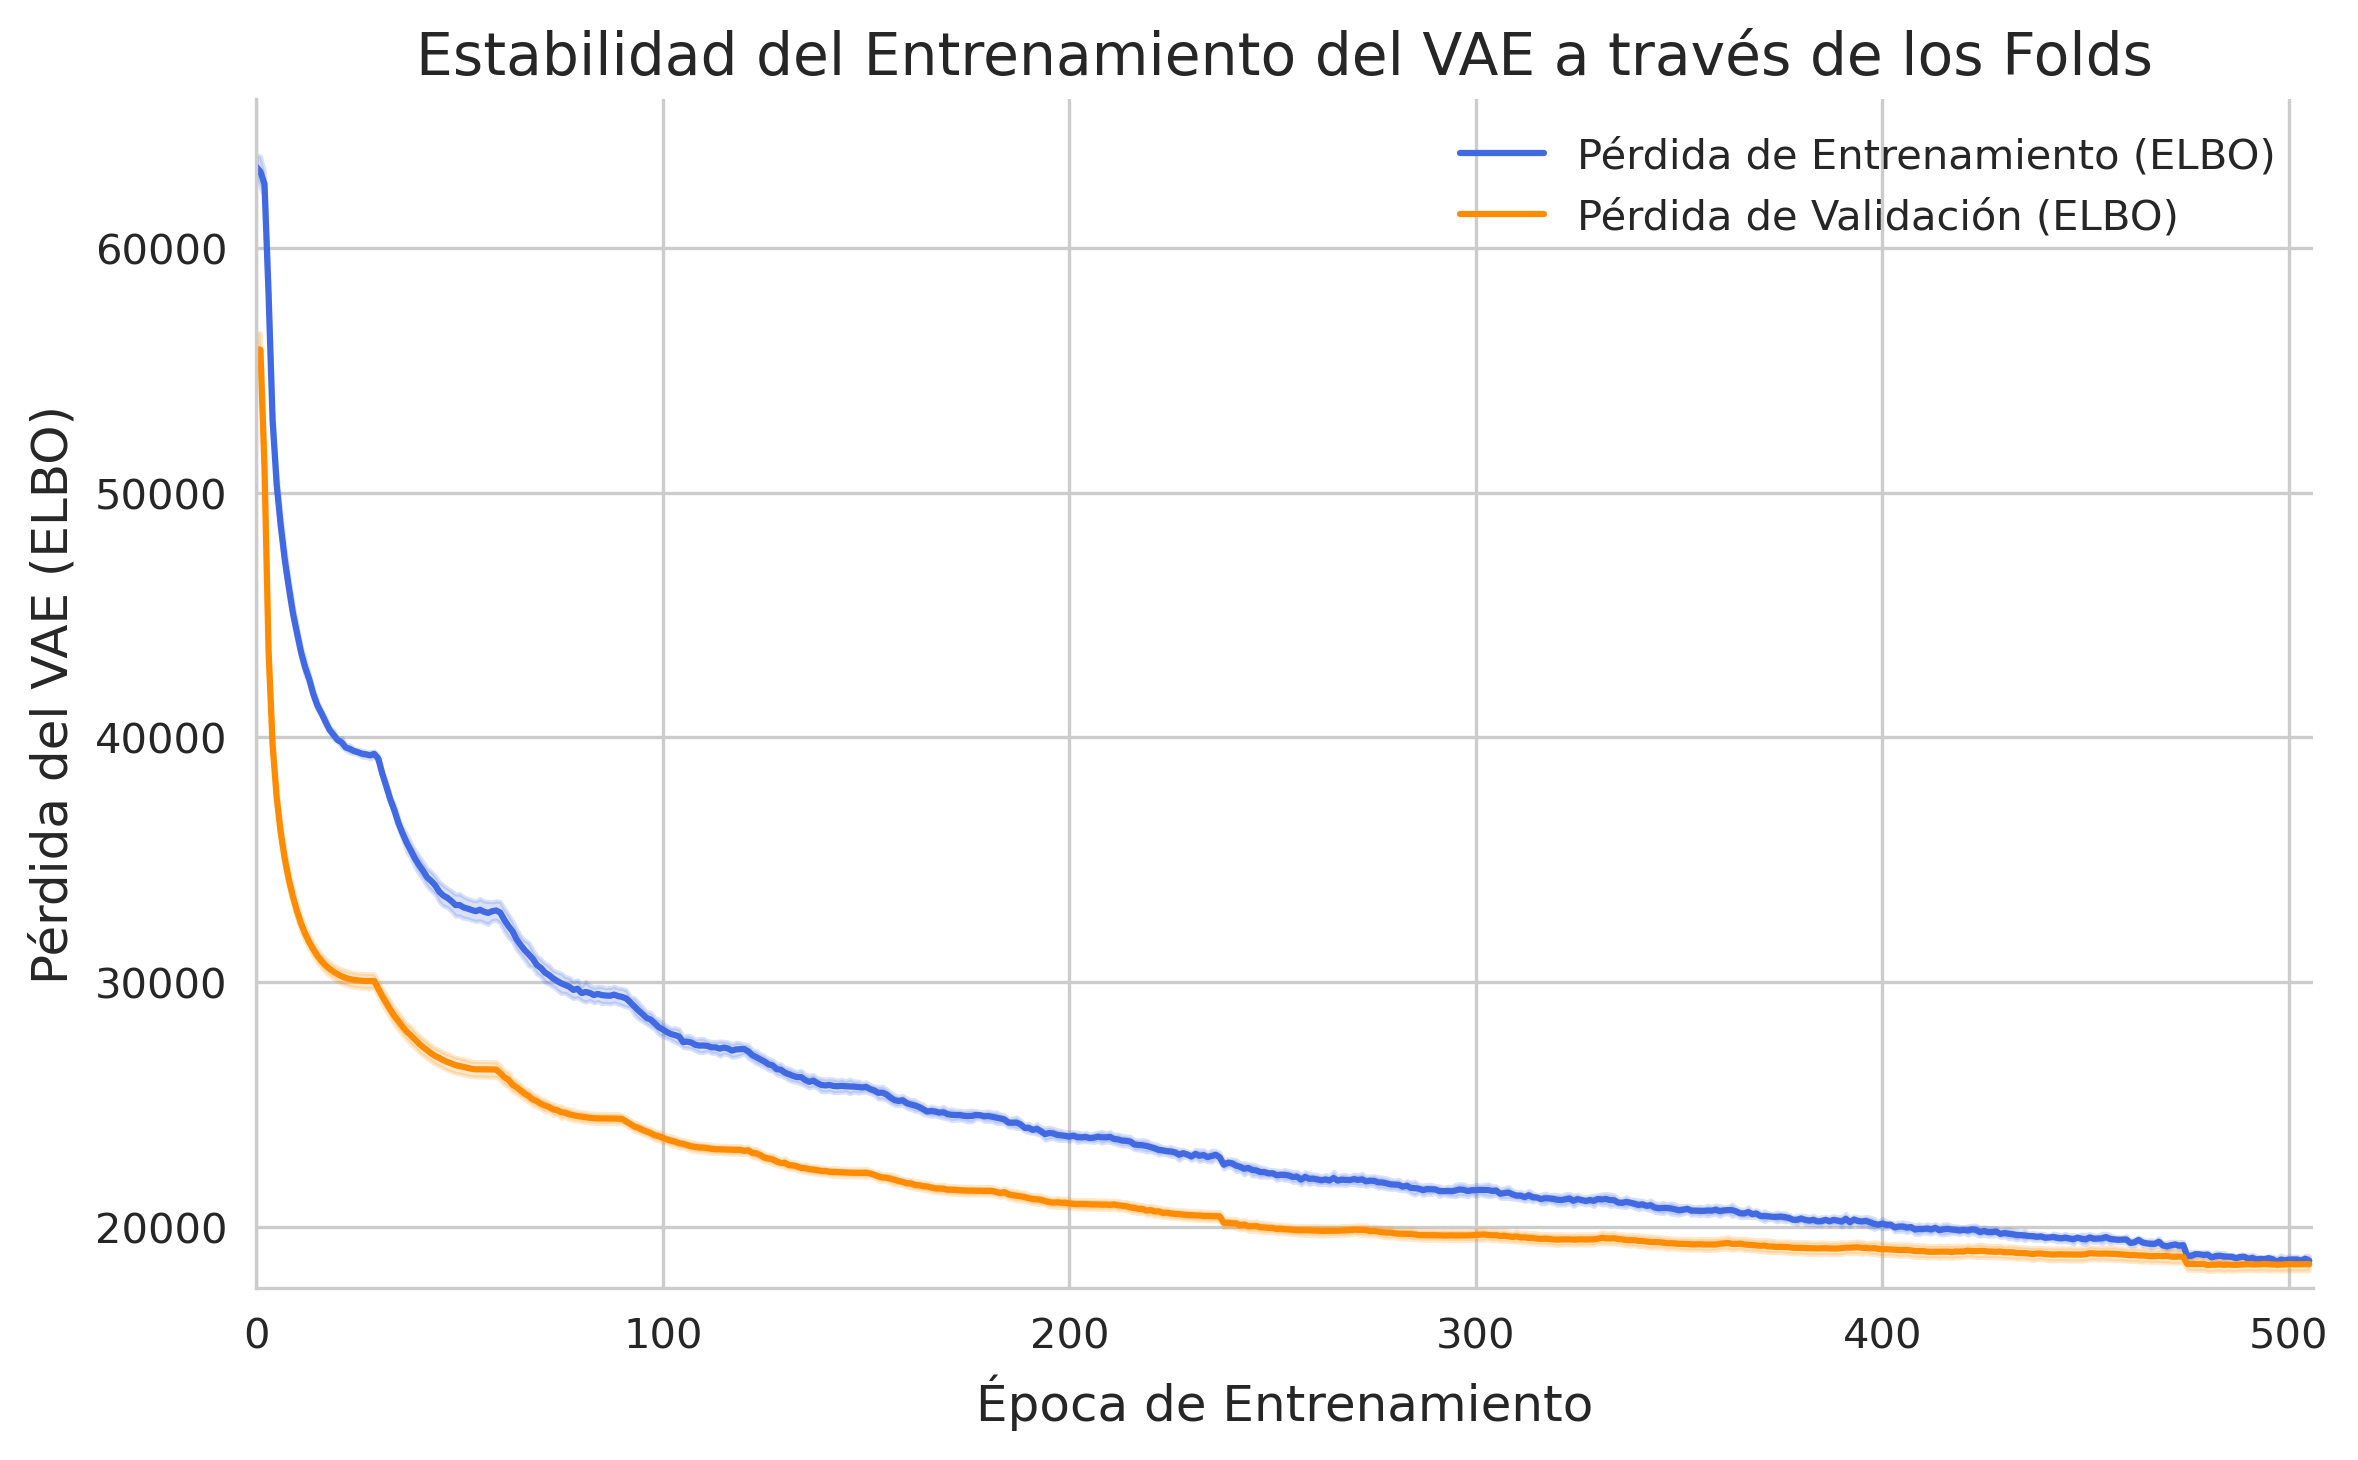

📄 Figura guardada en: resultados33/publication_figures/fig1_vae_training_curves.pdf


In [3]:
if histories is not None:
    # Truncar historiales a la longitud mínima para un promediado robusto
    min_len = min(len(h['train_loss']) for h in histories if h)
    
    # Recolectar datos de todos los folds
    train_loss = np.array([h['train_loss'][:min_len] for h in histories if h])
    val_loss = np.array([h['val_loss'][:min_len] for h in histories if h])
    
    mean_train, std_train = train_loss.mean(axis=0), train_loss.std(axis=0)
    mean_val, std_val = val_loss.mean(axis=0), val_loss.std(axis=0)
    
    epochs = np.arange(min_len)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(epochs, mean_train, color='royalblue', label='Pérdida de Entrenamiento (ELBO)')
    ax.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='royalblue', alpha=0.2)
    
    ax.plot(epochs, mean_val, color='darkorange', label='Pérdida de Validación (ELBO)')
    ax.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='darkorange', alpha=0.2)
    
    ax.set_xlabel("Época de Entrenamiento")
    ax.set_ylabel("Pérdida del VAE (ELBO)")
    ax.set_title("Estabilidad del Entrenamiento del VAE a través de los Folds")
    ax.legend(frameon=False)
    ax.set_xlim(0, min_len)
    ax.set_ylim(bottom=min(mean_val.min(), mean_train.min()) * 0.95) # Ajuste dinámico del eje Y
    sns.despine(ax=ax)
    
    plt.tight_layout()
    fig_path = OUTPUT_FIG_DIR / "fig1_vae_training_curves.pdf"
    fig.savefig(fig_path, dpi=300)
    plt.show()
    print(f"📄 Figura guardada en: {fig_path}")

/tmp/ipykernel_489958/2157130598.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


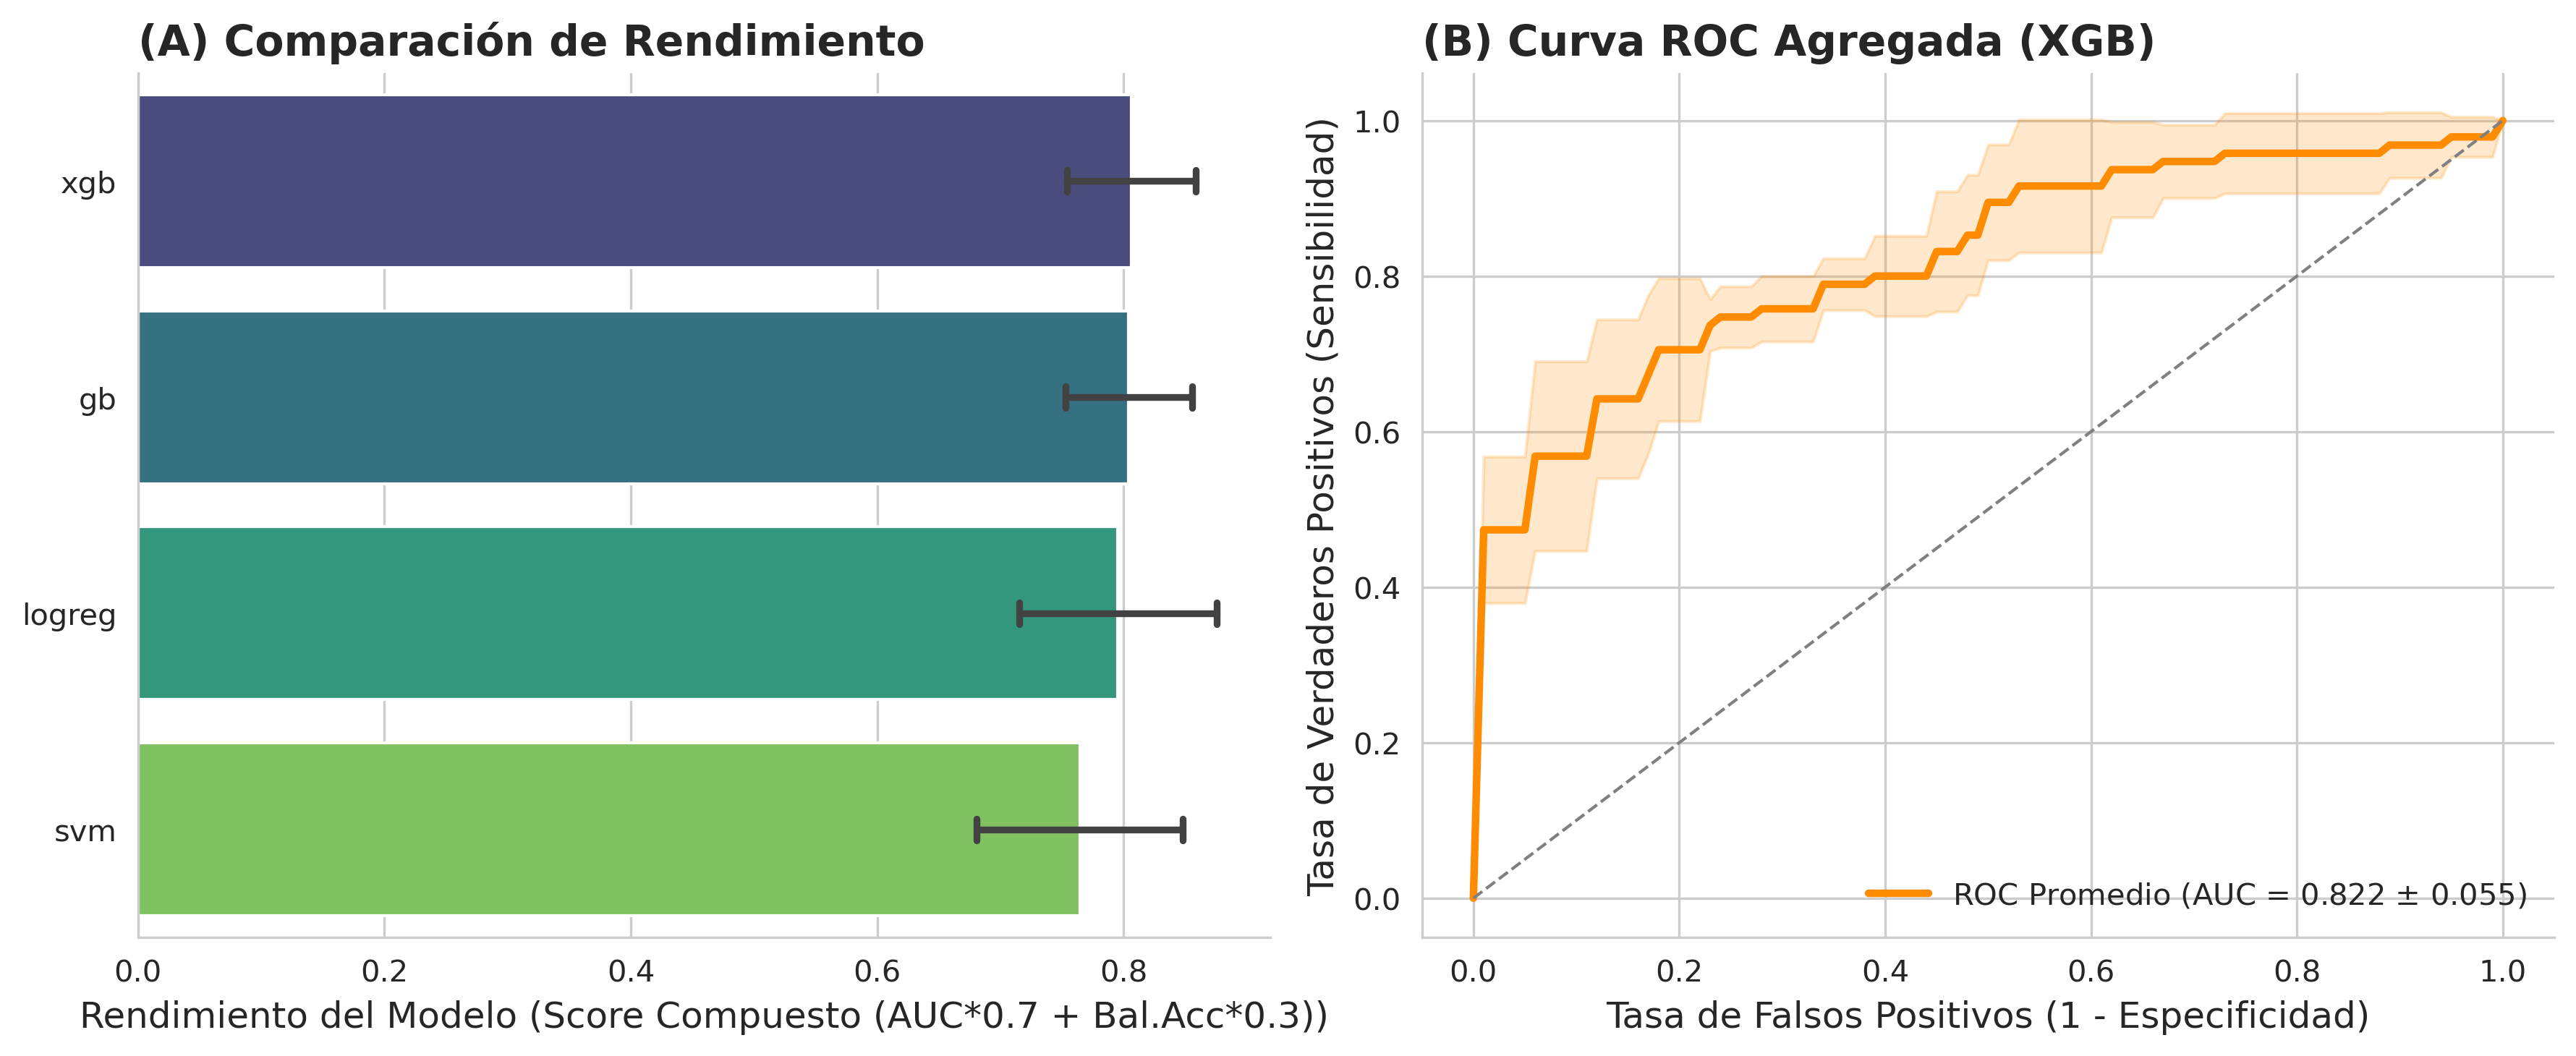

📄 Figura guardada en: resultados33/publication_figures/fig2_classifier_performance.pdf


In [4]:
if metrics_df is not None:
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2)

    # --- Panel A: Comparación de AUC ---
    ax1 = fig.add_subplot(gs[0, 0])
    order = metrics_df.groupby('classifier')[scoring_metric].mean().sort_values(ascending=False).index
    
    sns.barplot(
        data=metrics_df, y='classifier', x=scoring_metric,
        order=order, palette='viridis', ax=ax1,
        errorbar='sd', capsize=0.1
    )
    ax1.set_xlabel(f"Rendimiento del Modelo ({key_metrics[scoring_metric]})")
    ax1.set_ylabel("")
    ax1.set_title("(A) Comparación de Rendimiento", loc='left', weight='bold')
    sns.despine(ax=ax1)

    # --- Panel B: Curva ROC Agregada del Mejor Modelo ---
    ax2 = fig.add_subplot(gs[0, 1])
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    best_clf_preds = [p for p in predictions if p['classifier'] == best_clf_name]
    
    for pred in best_clf_preds:
        fpr, tpr, _ = roc_curve(pred['y_test'], pred['proba_test'])
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)
    
    mean_auc = auc(base_fpr, mean_tprs)
    auc_std = metrics_df[metrics_df["classifier"] == best_clf_name]["auc"].std()
    
    ax2.plot(base_fpr, mean_tprs, color='darkorange', lw=2.5, label=f'ROC Promedio (AUC = {mean_auc:.3f} $\\pm$ {auc_std:.3f})')
    ax2.fill_between(base_fpr, mean_tprs - std_tprs, mean_tprs + std_tprs, color='darkorange', alpha=0.2)
    ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    
    ax2.set_xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
    ax2.set_ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
    ax2.set_title(f"(B) Curva ROC Agregada ({best_clf_name.upper()})", loc='left', weight='bold')
    ax2.legend(loc='lower right', frameon=False)
    sns.despine(ax=ax2)

    plt.tight_layout()
    fig_path = OUTPUT_FIG_DIR / "fig2_classifier_performance.pdf"
    fig.savefig(fig_path, dpi=300)
    plt.show()
    print(f"📄 Figura guardada en: {fig_path}")

/home/diego/anaconda3/envs/serentipia_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🧠 Generando visualización UMAP por fold...


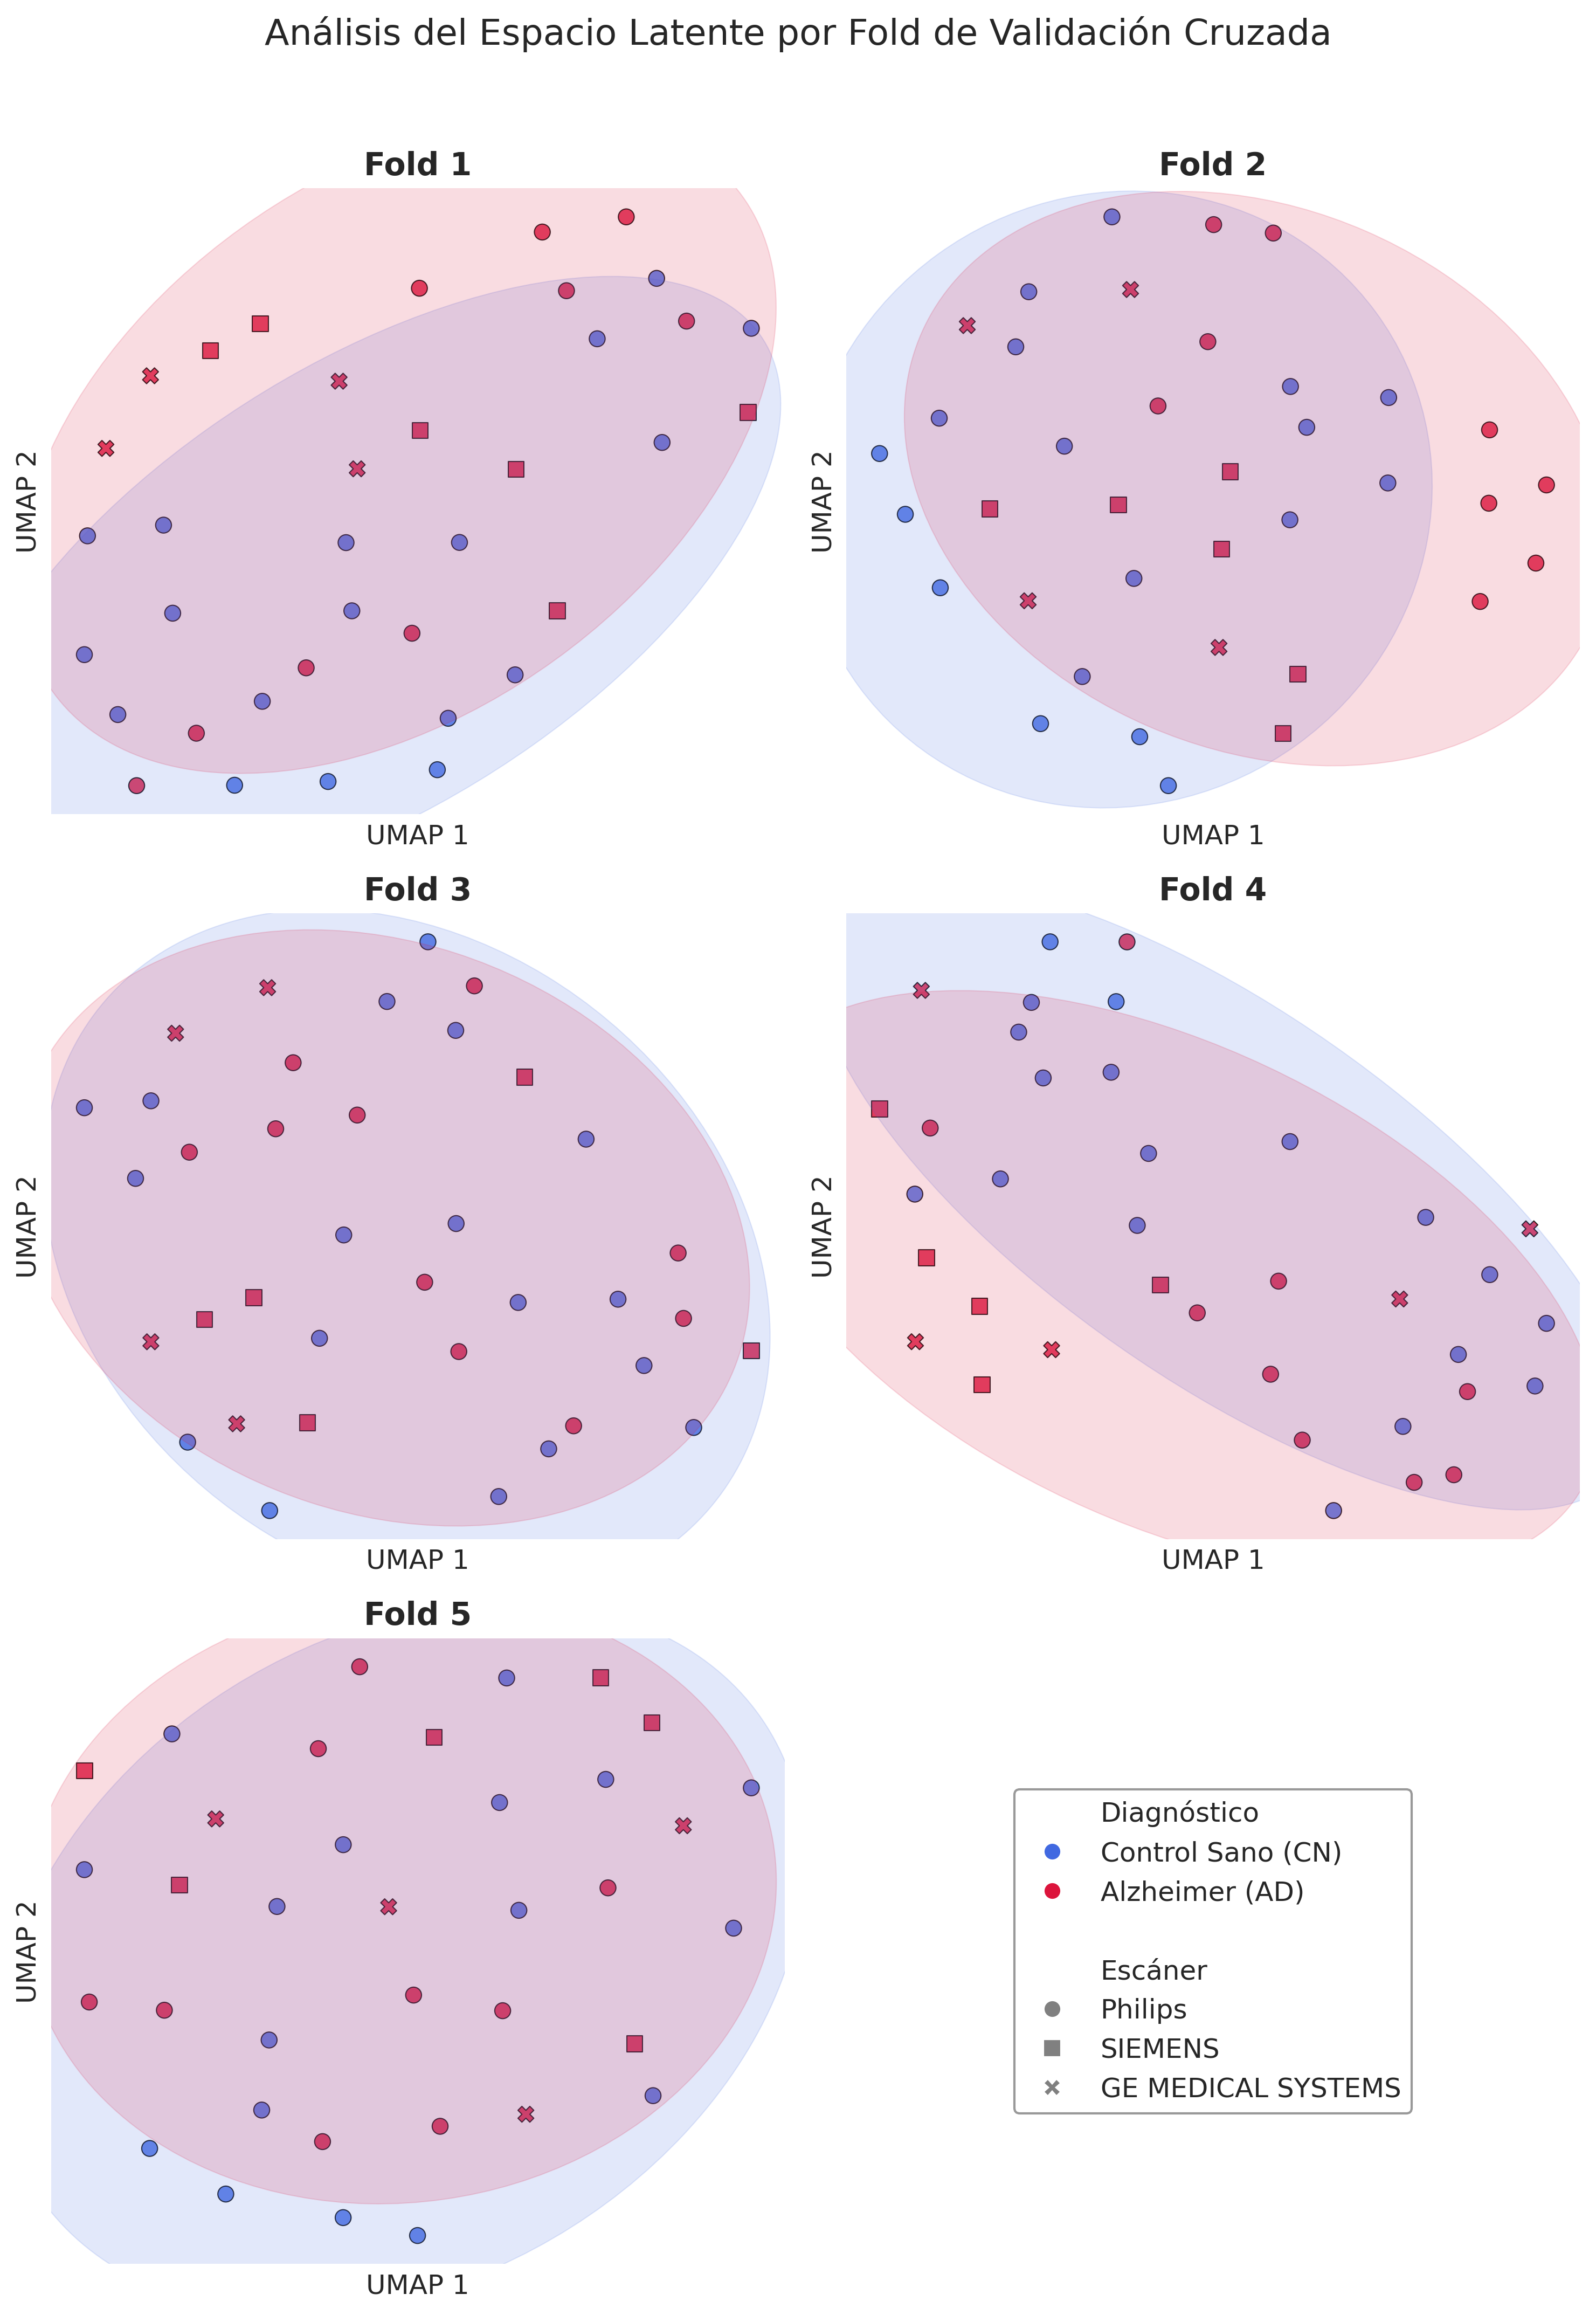

📄 Figura UMAP por fold de alta calidad guardada en: resultados33/publication_figures/fig3_umap_per_fold.pdf


In [5]:
import umap.umap_ as umap
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

# --- Funciones de Ayuda (las mismas de antes) ---
def umap_embedding(latent, n_neighbors=25, min_dist=0.05, metric='cosine', random_state=42):
    """Ejecuta UMAP sobre los datos latentes."""
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )
    return reducer.fit_transform(latent)

def confidence_ellipse(ax, x, y, n_std=1.96, **kwargs):
    """Añade una elipse de confianza del 95% a un scatter plot."""
    if len(x) < 2: return
    cov = np.cov(x, y); vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]; vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)), width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

# --- Mapeos para los colores y las formas ---
diag_palette = {'Control Sano (CN)': 'royalblue', 'Alzheimer (AD)': 'crimson'}
scanner_markers = {'Philips': 'o', 'SIEMENS': 's', 'GE MEDICAL SYSTEMS': 'X'}

# --- Crear la figura con una grilla de 3x2 ---
fig, axes = plt.subplots(3, 2, figsize=(10, 14))
axes_flat = axes.flatten()

print("🧠 Generando visualización UMAP por fold...")

# --- Iterar por cada fold para crear su subplot ---
for k in range(1, 6):
    ax = axes_flat[k-1]
    fold_dir = RESULTS_DIR / f"fold_{k}"
    
    # Cargar datos del fold
    latent_fold = np.load(fold_dir / "X_latent_test_mu.npy")
    meta_fold = pd.read_csv(fold_dir / "subjects_meta.csv")
    
    # Aplicar UMAP solo a los datos de este fold
    embedding_fold = umap_embedding(latent_fold)
    
    plot_df_fold = pd.DataFrame(embedding_fold, columns=['UMAP 1', 'UMAP 2'])
    plot_df_fold['Diagnóstico'] = np.where(meta_fold['label'] == 0, 'Control Sano (CN)', 'Alzheimer (AD)')
    plot_df_fold['Escáner'] = meta_fold['Manufacturer']
    
    # Dibujar el scatter plot usando HUE para color y STYLE para la forma
    sns.scatterplot(
        data=plot_df_fold, x='UMAP 1', y='UMAP 2',
        hue='Diagnóstico',
        style='Escáner',
        palette=diag_palette,
        markers=scanner_markers,
        s=50, alpha=0.8, ax=ax,
        edgecolor='k', linewidth=0.5,
        legend=False  # Desactivamos la leyenda individual
    )
    
    # Añadir elipses de confianza para el diagnóstico
    for cls, color in diag_palette.items():
        ix = plot_df_fold['Diagnóstico'] == cls
        if ix.sum() > 2:
            confidence_ellipse(ax, plot_df_fold.loc[ix, 'UMAP 1'], plot_df_fold.loc[ix, 'UMAP 2'],
                               facecolor=color, alpha=0.15, edgecolor=color, lw=0.5)
    
    ax.set_title(f"Fold {k}", loc='center', weight='bold')
    ax.set_xticks([]); ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)

# --- Crear una leyenda unificada en el último subplot vacío ---
ax_legend = axes_flat[-1]
ax_legend.axis('off') # Ocultar ejes

# Crear "artistas" para la leyenda
diag_handles = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
                for label, color in diag_palette.items()]
scan_handles = [Line2D([0], [0], marker=marker, color='w', label=label, markerfacecolor='gray', markersize=8)
                for label, marker in scanner_markers.items()]

# Añadir títulos a las leyendas
diag_title = [Line2D([],[],color='none',label="Diagnóstico", ls='')]
scan_title = [Line2D([],[],color='none',label=""), Line2D([],[],color='none',label="Escáner", ls='')] # Espacio

ax_legend.legend(
    handles=diag_title + diag_handles + scan_title + scan_handles,
    loc='center',
    frameon=True,
    edgecolor='gray',
    fontsize=12
)

fig.suptitle("Análisis del Espacio Latente por Fold de Validación Cruzada", fontsize=16, y=1.02)
plt.tight_layout()

# Guardar la figura
fig_path = OUTPUT_FIG_DIR / "fig3_umap_per_fold.pdf"
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
fig.savefig(fig_path.with_suffix(".png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"📄 Figura UMAP por fold de alta calidad guardada en: {fig_path}")